<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_07_03_survival_analysis_gradient_boosted_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.7.3 Gradient Boosted Survival Model  


Gradient Boosted Survival Models are a powerful class of machine learning models that extend traditional survival analysis techniques by incorporating gradient boosting methods. These models are particularly useful for predicting time-to-event outcomes while handling censored data effectively. This notebook provides an introduction to different types of Gradient Boosted Survival Models, focusing on their implementation in Python.  


## Overview


A **Gradient Boosted Survival Model** is a machine learning approach that combines gradient boosting with survival analysis to predict the time until an event of interest occurs, such as failure, death, or churn. Survival models deal with time-to-event data, which is often censored (i.e., the event hasn’t occurred for some subjects during the observation period). Gradient boosting enhances these models by iteratively building an ensemble of weak learners (typically decision trees) to minimize a loss function tailored to survival data.

There are several types of gradient boosted survival models, each tailored to specific survival analysis frameworks or assumptions. Thee most widely used models are **Cox Proportional Hazards-Based Gradient Boosting (CoxBoost)**,  **Gradient Boosting Survival Tree (GBST)**, and **Accelerated Failure Time (AFT) Gradient Boosting**. CoxBoost and GBST are fundamentally very similar, and in many contexts, GBST is simply a specific implementation of CoxBoost using decision trees as base learners. Coxboost can use various weak learners (trees, linear models, etc.), however, GBST is specifically designed for survival analysis and uses survival-specific splitting criteria in the trees. AFT Gradient Boosting, on the other hand, models the log-survival time directly and is based on a different assumption about how covariates affect survival time.



### Key Components


1. `Base Learners`: Typically decision trees, which are combined to form the final model.
2. `Loss Function`: A survival-specific loss, such as partial likelihood (Cox model-inspired) or a pseudo-residual-based loss.
3. `Gradient Descent`: Used to minimize the loss by adjusting the model in the direction of steepest descent.
4. `Regularization`: Techniques like shrinkage (learning rate) or tree depth constraints prevent overfitting.



### How it works


Gradient boosting iteratively adds decision trees, each correcting the errors of the previous ones, by optimizing a loss function (e.g., negative log-likelihood or a survival-specific loss). The model outputs predictions like survival probabilities, hazard functions, or cumulative risks over time, depending on the specific implementation.

In survival analysis, the model accounts for:

- `Censored data`: Observations where the event hasn’t occurred by the end of the study.
- `Time-to-event`: Predicting not just if an event occurs but when.
- `Risk or hazard`: Estimating the probability of the event at different time points.


- $ T_i $: True survival time for subject $ i $
- $ C_i $: Censoring time
- $ t_i = \min(T_i, C_i) $: Observed time
- $ \delta_i = \mathbb{I}(T_i \leq C_i) $: Event indicator (1 if event observed, 0 if censored)

We aim to model survival using a set of covariates $ \mathbf{x}_i \in \mathbb{R}^p $.



###  Cox Proportional Hazards-Based Gradient Boosting (CoxBoost)


Cox Proportional Hazards-Based Gradient Boosting is a machine learning approach that extends the Cox proportional hazards model by using gradient boosting to model the log-hazard function as a sum of decision trees. It assumes that the hazard ratios are constant over time (proportional hazards) and optimizes the negative log-partial likelihood to predict risk scores for survival data, accounting for censoring. This method excels in handling complex, non-linear relationships between covariates and survival outcomes, making it suitable for clinical applications like predicting patient survival in medical studies.

This method combines the Cox proportional hazards model with gradient boosting, where the base learners (e.g., regression trees) are used to iteratively improve the estimate of the log partial likelihood.


The hazard function for subject $ i $ is:

$$
h(t \mid \mathbf{x}_i) = h_0(t) \exp(\mathbf{x}_i^\top \boldsymbol{\beta})
$$

where:
- $ h_0(t) $: baseline hazard (non-parametric)

- $ \exp(\mathbf{x}_i^\top \boldsymbol{\beta}) $: relative risk

The partial log-likelihood (Cox, 1972) is:

$$
\ell(\boldsymbol{\beta}) = \sum_{i=1}^n \delta_i \left[ \mathbf{x}_i^\top \boldsymbol{\beta} - \log \left( \sum_{j \in \mathcal{R}(t_i)} \exp(\mathbf{x}_j^\top \boldsymbol{\beta}) \right) \right]
$$

where $ \mathcal{R}(t_i) = \{ j : t_j \geq t_i \} $ is the risk set at time $ t_i $.

Gradient Boosting Framework

Let $ f_m(\mathbf{x}) $ be the additive model at iteration $ m $:

$$
f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \cdot \gamma_m h_m(\mathbf{x})
$$

where:
- $ h_m(\mathbf{x}) $: weak learner (e.g., regression tree)

- $ \gamma_m $: coefficient

- $ \nu $: learning rate

In **CoxBoost**, the loss function is the negative log partial likelihood:

$$
L(y, f) = -\ell(f) = -\sum_{i=1}^n \delta_i \left[ f(\mathbf{x}_i) - \log \left( \sum_{j \in \mathcal{R}(t_i)} \exp(f(\mathbf{x}_j)) \right) \right]
$$

Gradients (pseudo-residuals) at step $ m $ are computed as:

$$
r_{im} = -\left[ \frac{\partial L}{\partial f(\mathbf{x}_i)} \right]_{f = f_{m-1}} = \delta_i - \sum_{j \in \mathcal{R}(t_i)} \frac{ \exp(f_{m-1}(\mathbf{x}_j)) }{ \sum_{k \in \mathcal{R}(t_i)} \exp(f_{m-1}(\mathbf{x}_k)) }
$$

This is the difference between the observed event indicator and the model-based risk weight (similar to a "score" residual).

Then:

- Fit a regression tree $ h_m(\mathbf{x}) $ to the pseudo-residuals $ r_{im} $

- Compute optimal $ \gamma_m $ by line search in the original Cox likelihood

- Update: $ f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \gamma_m h_m(\mathbf{x}) $

> **Note**: The baseline hazard $ h_0(t) $ remains unspecified; boosting estimates the log-risk $ f(\mathbf{x}) = \log h(t|\mathbf{x}) - \log h_0(t) $



### Gradient Boosting Survival Trees (GBST)


Gradient Boosting Survival Tree (GBST) is a specialized gradient boosting approach for survival analysis that uses survival trees as base learners, designed to handle time-to-event data with censoring. These trees split nodes based on survival-specific criteria, such as log-rank tests, to maximize differences in survival outcomes. GBST iteratively combines these trees to optimize a survival-related loss function, producing survival probabilities or hazard functions. Its strength lies in its interpretability and ability to model complex survival patterns without strict assumptions like proportional hazards, making it ideal for medical research applications like predicting patient survival times.

GBST is a **generic framework** for gradient boosting in survival analysis. It can be instantiated with different loss functions. The **CoxBoost** above is a special case of GBST.


Use a survival-specific loss $ \rho(t_i, \delta_i, f(\mathbf{x}_i)) $, e.g., Cox loss or others.

General boosting steps:

1. Initialize $ f_0(\mathbf{x}) = \arg\min_{c} \sum_{i=1}^n \rho(t_i, \delta_i, c) $

2. For $ m = 1 $ to $ M $:
   - Compute pseudo-residuals:
   
$$ r_{im} = -\left[ \frac{\partial \rho(t_i, \delta_i, f_{m-1}(\mathbf{x}_i))}{\partial f_{m-1}(\mathbf{x}_i)} \right]   $$
   - Fit a regression tree $ h_m(\mathbf{x}) $ to $ r_{im} $
   
   - Compute $ \gamma_m = \arg\min_\gamma \sum_{i=1}^n \rho(t_i, \delta_i, f_{m-1}(\mathbf{x}_i) + \gamma h_m(\mathbf{x}_i)) $
   
   - Update: $ f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \gamma_m h_m(\mathbf{x}) $

So **CoxBoost is a GBST with Cox partial likelihood loss**.

Other losses in GBST may include:

- Weighted log-likelihood
- Rank-based losses (e.g., concordance)
- Brier score for survival (integrated)


### Accelerated Failure Time (AFT) Gradient Boosting (AFTBoost)


Accelerated Failure Time (AFT) Gradient Boosting is a machine learning method for survival analysis that models the log-survival time as a function of covariates, assuming that predictors accelerate or decelerate the time to an event. It uses gradient boosting to combine decision trees, optimizing a likelihood-based loss function (e.g., Weibull or log-normal) that accounts for censored data. Unlike hazard-based models, AFT directly predicts survival times, making it intuitive for applications like predicting time to machine failure or patient recovery.

The AFT model assumes:

$$
\log T_i = \mathbf{x}_i^\top \boldsymbol{\beta} + \sigma \epsilon_i
$$

where $ \epsilon_i $ is an error term (e.g., normal, extreme value, logistic), and $ \sigma $ is a scale parameter.

This implies that covariates **accelerate or decelerate time**:

$$
T_i = \exp(\mathbf{x}_i^\top \boldsymbol{\beta}) \cdot V_i
$$

where $ V_i = \exp(\sigma \epsilon_i) $ is the baseline survival time.

`Likelihood with Censoring`:

Let $ y_i = \log t_i $. The observed log-time and event indicator define the likelihood contribution:

$$
\mathcal{L}_i = \left[ \frac{1}{\sigma} f_\epsilon\left( \frac{y_i - \mathbf{x}_i^\top \boldsymbol{\beta}}{\sigma} \right) \right]^{\delta_i} \cdot \left[ 1 - F_\epsilon\left( \frac{y_i - \mathbf{x}_i^\top \boldsymbol{\beta}}{\sigma} \right) \right]^{1 - \delta_i}
$$

where $ f_\epsilon $ and $ F_\epsilon $ are the PDF and CDF of the error distribution.

Common choices:
- Normal: $ \epsilon \sim \mathcal{N}(0,1) $ → log-normal AFT

- Extreme value: $ \epsilon \sim \text{Gumbel} $ → Weibull AFT

`Gradient Boosting for AFT`:

Let $ f(\mathbf{x}) $ model $ \mathbf{x}^\top \boldsymbol{\beta} $, and optionally $ s(\mathbf{x}) $ model $ \log \sigma $.

**Case 1: Fixed $ \sigma $**

Use log-likelihood as loss:

$$
L(f) = -\sum_{i=1}^n \left[ \delta_i \log f_\epsilon\left( \frac{y_i - f(\mathbf{x}_i)}{\sigma} \right) + (1 - \delta_i) \log \left(1 - F_\epsilon\left( \frac{y_i - f(\mathbf{x}_i)}{\sigma} \right)\right) \right]
$$

Pseudo-residuals:

$$
r_{im} = -\left[ \frac{\partial L}{\partial f(\mathbf{x}_i)} \right]_{f = f_{m-1}} = \delta_i \cdot \frac{ f_\epsilon'\left( z_i^{(m-1)} \right) }{ f_\epsilon\left( z_i^{(m-1)} \right) } + (1 - \delta_i) \cdot \frac{ f_\epsilon\left( z_i^{(m-1)} \right) }{ 1 - F_\epsilon\left( z_i^{(m-1)} \right) }
$$

where $ z_i^{(m-1)} = \frac{y_i - f_{m-1}(\mathbf{x}_i)}{\sigma} $

Then:
- Fit tree $ h_m(\mathbf{x}) $ to $ r_{im} $

- Update $ f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \gamma_m h_m(\mathbf{x}) $

**Case 2: Learn $ \sigma $ jointly**

Use two models:

- $ f(\mathbf{x}) $: location (mean)

- $ s(\mathbf{x}) $: log-scale


### Comparison: Similarities and Differences


| Feature | **CoxBoost** | **GBST** | **AFTBoost** |
|--------|------------|----------|------------|
| **Model Type** | Semi-parametric (PH) | Framework (can be PH or other) | Parametric (AFT) |
| **Assumption** | Proportional hazards | Depends on loss | Accelerated time |
| **Loss Function** | Negative partial Cox log-likelihood | Any survival loss (Cox, rank, etc.) | Full log-likelihood (with censoring) |
| **Output** | Log-hazard ratio $ f(\mathbf{x}) $ | Flexible (depends on loss) | $ \log T_i $ prediction |
| **Baseline** | $ h_0(t) $ unspecified | Depends on loss | Parametric baseline distribution |
| **Gradient Form** | $ r_{im} = \delta_i - \sum_{j \in \mathcal{R}(t_i)} w_j $ | $ r_{im} = -\partial \rho / \partial f $ | $ r_{im} = \text{likelihood score} $ |
| **Interpretability** | Hazard ratios | Depends on loss | Time acceleration factor $ \exp(\beta_j) $ |
| **Tree Fitting** | On pseudo-residuals | On pseudo-residuals | On pseudo-residuals |
| **Prediction** | Risk score, survival curves (via Breslow) | Depends on loss | Predict $ \log T_i $, simulate survival |



## Setup and Installation

In [ ]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', \
    'seaborn', 'scikit-learn', 'scikit-survival', \
        'lifelines', 'statsmodels', 'pymer4', 'PyMC', 'polars', 'xgboost']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
lifelines is already installed
statsmodels is already installed
Installing pymer4...
Failed to install pymer4: No module named 'rpy2'
Error with package pymer4: No module named 'rpy2'
Installing PyMC...
Failed to install PyMC: No module named 'PyMC'
Error with package PyMC: No module named 'PyMC'
polars is already installed
Installing xgboost...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 33.1 MB/s  0:00:03m0:00:0100:01
xgboost installed successfully
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-surviva

In [ ]:
# Install required packages if needed
# !pip install scikit-survival lifelines pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## Gradient Boosted Survival Models with Python


This section provides a comprehensive guide to implementing the CoxBoost, GBST and AFTBoost using Python, specifically utilizing the `scikit-survival`, `xgboost`, and `lifelines` packages. The steps include loading necessary libraries, preparing the dataset, fitting the model, validating it, and visualizing results.



## Cox Proportional Hazards-Based Gradient Boosting (CoxBoost)


The Cox Proportional Hazards-Based Gradient Boosting Model combines the Cox proportional hazards framework with gradient boosting to model survival data, capturing non-linear relationships and interactions while handling censored observations. In Python, packages like `scikit-survival`, `xgboost`, and `lifelines` enable this approach. Below is a step-by-step implementation of CoxBoost model, including data preparation, model fitting, validation, and visualization.  It is a semi-parametric regression model widely used for such tasks. The classical Cox model assumes:

- Linear effects of covariates

- Proportional hazards

- No interactions unless explicitly added

To overcome these limitations, **gradient boosting** can be adapted to optimize the **partial likelihood** of the Cox model. This results in a **boosted Cox model** that learns complex, non-linear patterns in the data by sequentially fitting weak learners (typically decision trees) to improve survival risk predictions. This approach is implemented in libraries like `scikit-survival`, `xgboost` using a custom objective function based on the **Cox partial log-likelihood**.


### Data and Data Preparation


First, ensure you have the required packages installed and load the `lung` dataset. The `lung` dataset contains survival data for 228 patients with advanced lung cancer, including variables like `time` (survival time in days), `status` (censoring indicator: 1 = censored, 2 = dead), and covariates like `age`, `sex`, `ph.ecog`, etc.



In [ ]:
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/lung_dataset.csv"
lung = pd.read_csv(url)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
np.random.seed(123)

# Assuming 'lung' DataFrame is already loaded (from previous cell)
# Remove missing values
lung_complete = lung.dropna()

# Split into 70% training and 30% testing
train_data, test_data = train_test_split(lung_complete, test_size=0.3, random_state=123)

# Training data
time_train = train_data["time"].values
status_train = train_data["status"].values
X_train = train_data.drop(columns=["time", "status"])
X_train_matrix = X_train.values

# Test data
time_test = test_data["time"].values
status_test = test_data["status"].values
X_test = test_data.drop(columns=["time", "status"])
X_test_matrix = X_test.values


### Fit Initial CoxBoost Model



First, we fit an initial CoxBoost model using the training data. This model will be used to estimate the baseline cumulative hazard and compute survival curves. We'll use `GradientBoostingSurvivalAnalysis` from `scikit-survival` or `xgboost` with Cox objective to fit the model. The `n_estimators` parameter controls the number of boosting iterations, and we can use regularization parameters to prevent overfitting.


In [ ]:
# Fit initial CoxBoost model using GradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv

# Prepare survival array for scikit-survival
# Convert status: 1=censored, 2=event -> True=event, False=censored
y_train_sksurv = np.array([(status_train[i] == 2, time_train[i]) for i in range(len(time_train))],
                          dtype=[('status', bool), ('time', float)])

# Fit initial model
initial_model = GradientBoostingSurvivalAnalysis(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=123
)

initial_model.fit(X_train_matrix, y_train_sksurv)

print(f"Initial model fitted with {initial_model.n_estimators} estimators")
print(f"Number of features: {X_train_matrix.shape[1]}")

Initial model fitted with 100 estimators
Number of features: 8


In [ ]:
# Variables and attributes of the fitted model
print("Model attributes:")
print(f"- n_estimators: {initial_model.n_estimators}")
print(f"- learning_rate: {initial_model.learning_rate}")
print(f"- max_depth: {initial_model.max_depth}")
print(f"- feature_importances_: {initial_model.feature_importances_}")

Model attributes:
- n_estimators: 100
- learning_rate: 0.1
- max_depth: 3
- feature_importances_: [0.14372795 0.20922343 0.05504586 0.07659514 0.11020907 0.09753798
 0.11928167 0.18837888]


In [ ]:
# Feature importances (equivalent to coefficients in boosted models)
print(f"Feature importances shape: {initial_model.feature_importances_.shape}")
print(f"Feature importances: {initial_model.feature_importances_}")

Feature importances shape: (8,)
Feature importances: [0.14372795 0.20922343 0.05504586 0.07659514 0.11020907 0.09753798
 0.11928167 0.18837888]


In [ ]:
# Predict risk scores (linear predictor estimates)
initial_pred_train = initial_model.predict(X_train_matrix)
print(f"Predicted risk scores shape: {initial_pred_train.shape}")
print(f"Sample risk scores: {initial_pred_train[:5]}")

Predicted risk scores shape: (116,)
Sample risk scores: [-0.71049313  0.43868593 -1.40884016 -1.82458442  0.75214591]


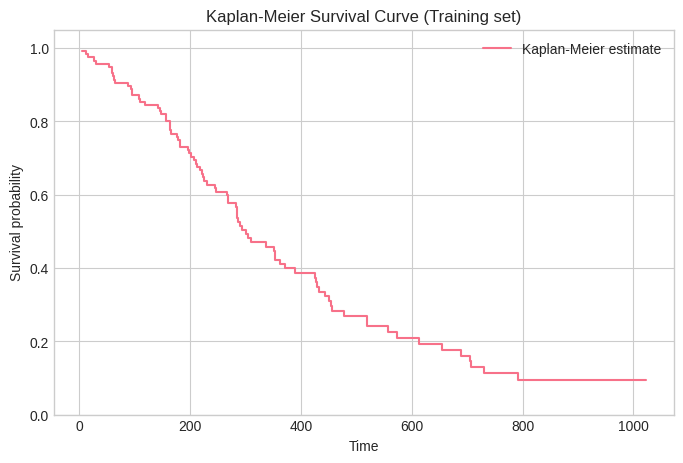

In [ ]:
# Calculate and plot Kaplan-Meier survival curve for the training set
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# status_train: 1=censored, 2=event
# time_train: durations

# Boolean event indicator for KM: True if event occurred (status==2), False if censored (status==1)
event_observed = np.array(status_train) == 2
time_observed = np.array(time_train)

# Calculate Kaplan-Meier estimator
km_time, km_survival = kaplan_meier_estimator(event_observed, time_observed)

# Plot
plt.figure(figsize=(8, 5))
plt.step(km_time, km_survival, where="post", label="Kaplan-Meier estimate")
plt.title("Kaplan-Meier Survival Curve (Training set)")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.show()

### Prediction and Validation

In [ ]:
# Initial model validation on test data
# Get risk scores (higher risk = shorter survival)
initial_pred = initial_model.predict(X_test_matrix)
print(f"Initial predictions shape: {initial_pred.shape}")
print(f"Sample predictions: {initial_pred[:5]}")


Initial predictions shape: (51,)
Sample predictions: [-0.08157647 -0.83325116  1.79488377  0.50425948 -0.48988063]


In [ ]:
# Predictions are already a vector in scikit-survival
initial_pred_vec = initial_pred
print(f"Prediction vector shape: {initial_pred_vec.shape}")

Prediction vector shape: (51,)


### C-Index of Initial Model


C-index is a measure of the model's discriminatory ability, indicating how well the model can distinguish between individuals who experience the event and those who do not. A C-index of 0.5 indicates no discrimination (random prediction), while a C-index of 1.0 indicates perfect discrimination.


In [ ]:
# Custom C-index function as a fallback
def custom_cindex(pred, time, status):
    """
    Calculate concordance index (C-index) manually.
    Higher risk scores should correspond to shorter survival times.
    """
    concordant = 0
    total_pairs = 0
    n = len(time)

    for i in range(n - 1):
        for j in range(i + 1, n):
            # Both events observed
            if status[i] == 2 and status[j] == 2:  # Both dead
                if time[i] < time[j] and pred[i] > pred[j]:
                    concordant += 1
                if time[j] < time[i] and pred[j] > pred[i]:
                    concordant += 1
                total_pairs += 1
            # i event, j censored
            elif status[i] == 2 and status[j] == 1:  # i dead, j censored
                if time[i] < time[j] and pred[i] > pred[j]:
                    concordant += 1
                total_pairs += 1
            # j event, i censored
            elif status[j] == 2 and status[i] == 1:  # j dead, i censored
                if time[j] < time[i] and pred[j] > pred[i]:
                    concordant += 1
                total_pairs += 1

    if total_pairs == 0:
        return np.nan
    return concordant / total_pairs

In [ ]:
# Calculate C-index using scikit-survival
from sksurv.metrics import concordance_index_censored

# Convert status: 1=censored, 2=event -> event=True, censored=False
event_test = (status_test == 2)

# Calculate C-index
# Note: Higher risk scores should predict shorter survival, so we negate predictions
initial_cindex_result = concordance_index_censored(
    event_indicator=event_test,
    event_time=time_test,
    estimate=-initial_pred_vec  # Negate because higher risk = shorter survival
)
initial_cindex = initial_cindex_result[0]

print(f"Initial model C-index: {initial_cindex:.3f}")

Initial model C-index: 0.381


### Integrated Brier Score (IBS)


The Integrated Brier Score (IBS) is a metric used to evaluate the predictive performance of survival models, such as the CoxBoost model in your script. It measures the mean squared error of predicted survival probabilities over a specified time range, accounting for censoring


In [ ]:
# Manual IBS calculation with proper alignment of survival prediction columns to evaluation times
from sksurv.metrics import integrated_brier_score
from sksurv.nonparametric import kaplan_meier_estimator

# Restrict eval_times to within the observed range of test times (open interval)
t_min = np.min(time_test)
t_max = np.max(time_test)
eps = 1e-8
eval_times = np.linspace(t_min + eps, t_max - eps, 100)

# Get sksurv-compatible test event/censor array
y_test_sksurv = np.array([(status_test[i] == 2, time_test[i]) for i in range(len(time_test))],
                         dtype=[('status', bool), ('time', float)])

# Predict survival functions for test set
# initial_surv_pred is (n_samples, n_model_time_points)
surv_funcs = initial_model.predict_survival_function(X_test_matrix)

# Interpolate each individual's survival function to match eval_times
from scipy.interpolate import interp1d
aligned_surv_pred = np.empty((len(surv_funcs), len(eval_times)), dtype=np.float64)
for i, surv in enumerate(surv_funcs):
    model_times = surv.x
    model_surv = surv.y
    interp_fn = interp1d(model_times, model_surv, kind='previous',
                         bounds_error=False, fill_value=(1.0, model_surv[-1] if len(model_surv) > 0 else 0.0))
    aligned_surv_pred[i, :] = np.clip(interp_fn(eval_times), 0, 1)

# Estimate censoring distribution using Kaplan-Meier (not actually used here, but left for reference)
censor_indicator = (status_test == 1)  # 1 = censored
km_censor = kaplan_meier_estimator(censor_indicator, time_test)

# Calculate Integrated Brier Score using matched shapes
initial_ibs = integrated_brier_score(
    y_train_sksurv, y_test_sksurv, aligned_surv_pred, eval_times
)

print(f"Initial model IBS: {initial_ibs:.3f}")

Initial model IBS: 0.173


### Kaplan-Meier baseline IBS


The Kaplan-Meier baseline Integrated Brier Score (IBS) is calculated using the Kaplan-Meier survival estimates as a baseline for comparison. This provides a reference point to evaluate the performance of the CoxBoost model against a non-parametric survival estimate.


In [ ]:
# Kaplan-Meier baseline IBS
from sksurv.nonparametric import kaplan_meier_estimator

# Fit Kaplan-Meier on test data
km_times, km_surv = kaplan_meier_estimator(event_test, time_test)

# Interpolate survival probabilities at evaluation times
from scipy.interpolate import interp1d
km_interp = interp1d(km_times, km_surv, kind='previous',
                     bounds_error=False, fill_value=(1.0, km_surv[-1] if len(km_surv) > 0 else 0.0))
km_surv_eval = km_interp(eval_times)
km_surv_eval = np.clip(km_surv_eval, 0, 1)

# Create survival prediction matrix (same for all subjects)
km_surv_matrix = np.tile(km_surv_eval, (len(time_test), 1))

# Calculate IBS for Kaplan-Meier
km_ibs = integrated_brier_score(
    y_train_sksurv, y_test_sksurv, km_surv_matrix, eval_times
)

print(f"Kaplan-Meier baseline IBS: {km_ibs:.3f}")

Kaplan-Meier baseline IBS: 0.157


### Crosss-Validation for Penalty Parameter


Cross-validation is used to select the optimal hyperparameters for the CoxBoost model. We can use `GridSearchCV` or manual cross-validation to find the best learning rate, number of estimators, and tree depth. The optimal parameters are chosen based on the best C-index or integrated Brier score.



In [ ]:
# Cross-validation for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

# Create a scorer based on C-index
def c_index_scorer(estimator, X, y):
    """Scorer function for C-index"""
    pred = estimator.predict(X)
    event_indicator = y['status']
    event_time = y['time']
    result = concordance_index_censored(event_indicator, event_time, -pred)
    return result[0]

# No make_scorer in sksurv.metrics. Use scorer as a callable directly.
# When passing a callable as scoring, GridSearchCV expects signature (estimator, X, y)
scorer = c_index_scorer

# Perform grid search with cross-validation
print("Performing grid search for optimal hyperparameters...")
cv_model = GridSearchCV(
    GradientBoostingSurvivalAnalysis(random_state=123, subsample=0.8),
    param_grid,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
)

cv_model.fit(X_train_matrix, y_train_sksurv)

print(f"\nBest parameters: {cv_model.best_params_}")
print(f"Best cross-validation score (C-index): {cv_model.best_score_:.3f}")

Performing grid search for optimal hyperparameters...
Fitting 5 folds for each of 27 candidates, totalling 135 fits



Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}
Best cross-validation score (C-index): 0.456


In [ ]:
# Extract optimal parameters
optimal_params = cv_model.best_params_
print(f"Optimal parameters: {optimal_params}")

Optimal parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}


### Cross-Validation for Boosting Steps


The optimal number of boosting iterations can also be determined using early stopping or cross-validation. We can use the `best_params_` from grid search or perform additional validation to find the optimal number of estimators.


In [ ]:
# Use optimal parameters from grid search
optimal_steps = optimal_params.get('n_estimators', 100)
optimal_learning_rate = optimal_params.get('learning_rate', 0.1)
optimal_max_depth = optimal_params.get('max_depth', 3)

print(f"Optimal number of estimators: {optimal_steps}")
print(f"Optimal learning rate: {optimal_learning_rate}")
print(f"Optimal max depth: {optimal_max_depth}")

Optimal number of estimators: 100
Optimal learning rate: 0.01
Optimal max depth: 2


### Fit Final Model


Now that we have the optimal hyperparameters, we can fit the final CoxBoost model using these parameters. The `GradientBoostingSurvivalAnalysis` is used with the optimal parameters obtained from cross-validation. The model is fitted on the training data, and a summary of the model is printed.


In [ ]:
# Fit final model with optimal parameters
final_model = GradientBoostingSurvivalAnalysis(
    n_estimators=optimal_steps,
    learning_rate=optimal_learning_rate,
    max_depth=optimal_max_depth,
    subsample=0.8,
    random_state=123
)

final_model.fit(X_train_matrix, y_train_sksurv)

print(f"Final model fitted with {final_model.n_estimators} estimators")
print(f"Learning rate: {final_model.learning_rate}")
print(f"Max depth: {final_model.max_depth}")
print(f"\nFeature importances:")
for i, feature in enumerate(X_train.columns):
    print(f"  {feature}: {final_model.feature_importances_[i]:.4f}")


Final model fitted with 100 estimators
Learning rate: 0.01
Max depth: 2

Feature importances:
  inst: 0.0867
  age: 0.1261
  sex: 0.0978
  ph.ecog: 0.0761
  ph.karno: 0.1359
  pat.karno: 0.1981
  meal.cal: 0.0369
  wt.loss: 0.2425


### Final model validation on test data

In [ ]:
# Prediction on test data
final_pred = final_model.predict(X_test_matrix)
final_pred_vec = final_pred
print(f"Final predictions shape: {final_pred_vec.shape}")


Final predictions shape: (51,)


In [ ]:
# Calculate C-index for final model
final_cindex_result = concordance_index_censored(
    event_indicator=event_test,
    event_time=time_test,
    estimate=-final_pred_vec  # Negate because higher risk = shorter survival
)
final_cindex = final_cindex_result[0]

print(f"Final model C-index: {final_cindex:.3f}")


Final model C-index: 0.371


In [ ]:
# Calculate IBS for final model

# Generate survival predictions at the same time points as eval_times to match the expected shape for IBS input
final_surv_pred_funcs = final_model.predict_survival_function(X_test_matrix)
final_surv_pred = np.asarray([
    fn(eval_times) for fn in final_surv_pred_funcs
])

final_ibs = integrated_brier_score(
    y_train_sksurv, y_test_sksurv, final_surv_pred, eval_times
)

print(f"Final model IBS: {final_ibs:.3f}")

Final model IBS: 0.153


### Survival Curves


Finally, we can visualize the survival curves based on the predicted risk scores from the final CoxBoost model. The survival probabilities are computed from the cumulative incidence function (CIF) estimates, and a plot is generated to show the average survival curve across all test samples.


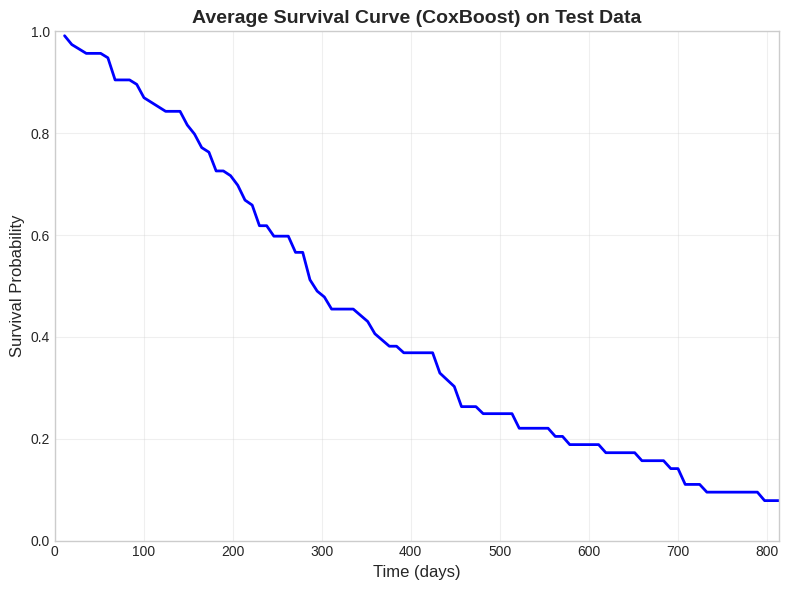

In [ ]:
# Plot average survival curve
avg_surv_final = np.mean(final_surv_pred, axis=0)
surv_data = pd.DataFrame({
    'time': eval_times,
    'surv': avg_surv_final
})

plt.figure(figsize=(8, 6))
plt.plot(surv_data['time'], surv_data['surv'], color='blue', linewidth=2)
plt.title('Average Survival Curve (CoxBoost) on Test Data', fontsize=14, fontweight='bold')
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, max(eval_times))
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### Variable Importance


Variable importance can be assessed by examining the absolute values of the coefficients from the final CoxBoost model. This provides insights into which predictors have the most significant impact on survival risk.


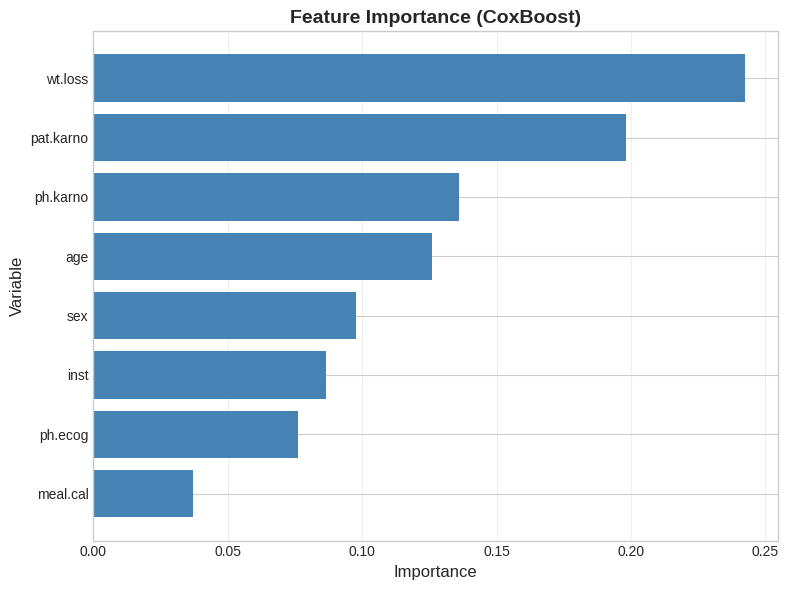

In [ ]:
# Variable importance plot
importance = final_model.feature_importances_
imp_data = pd.DataFrame({
    'Variable': X_train.columns,
    'Importance': importance
})
imp_data = imp_data[imp_data['Importance'] > 0].sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(imp_data['Variable'], imp_data['Importance'], color='steelblue')
plt.title('Feature Importance (CoxBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## Gradient Boosting Survival Tree (GBST)



GBST applies gradient boosting directly to survival data using tree-based models, but it typically uses `rank-based` or `log-likelihood` loss functions tailored to survival, such as the log partial likelihood (Cox-type) or concordance-based loss. It extends the gradient boosting framework—popularized by algorithms like Gradient Boosting Machines (GBM) and XGBoost—to handle survival outcomes by optimizing survival-specific loss functions. Unlike traditional survival models such as the **Cox proportional hazards model**, GBST does not assume proportional hazards. GBST can capture complex, non-linear relationships and interactions in the data. GBST may use different loss functions (e.g., ranking), while CoxBoost specifically targets the Cox partial likelihood.



### GBST with gbm


GBST operates similarly to CoxBoost by integrating the Cox proportional hazards model with gradient boosting techniques for analyzing survival data. This approach allows for flexible modeling of survival times while accounting for censoring, making it suitable for complex survival datasets. In Python, we can use `scikit-survival`'s `GradientBoostingSurvivalAnalysis` or `xgboost` with Cox objective to implement this method. Below is a step-by-step guide to fitting a GBST model using Python, including data preparation, model fitting, validation, and visualization.



#### Load and Prepare Data

In [ ]:
# Set seed for reproducibility
np.random.seed(123)

# Prepare lung dataset (already loaded)
# Remove missing values
lung_complete = lung.dropna()

# Split into 70% training and 30% testing
train_data, test_data = train_test_split(lung_complete, test_size=0.3, random_state=123)

# Prepare survival arrays
y_train_gbst = np.array([(train_data['status'].iloc[i] == 2, train_data['time'].iloc[i])
                         for i in range(len(train_data))],
                        dtype=[('status', bool), ('time', float)])
y_test_gbst = np.array([(test_data['status'].iloc[i] == 2, test_data['time'].iloc[i])
                        for i in range(len(test_data))],
                       dtype=[('status', bool), ('time', float)])

# Prepare feature matrices
X_train_gbst = train_data.drop(columns=['time', 'status']).values
X_test_gbst = test_data.drop(columns=['time', 'status']).values


#### Fit GBST Model


GBST is implemented using `scikit-survival`'s `GradientBoostingSurvivalAnalysis`, which allows for fitting gradient boosting models with Cox partial likelihood loss. This is equivalent to using `distribution = "coxph"` in R's `gbm` package.



In [ ]:
# Fit Gradient Boosting Survival Tree model
gbst_model = GradientBoostingSurvivalAnalysis(
    n_estimators=1000,              # Number of boosting iterations
    learning_rate=0.01,             # Learning rate (shrinkage)
    max_depth=3,                    # Tree depth (interaction.depth)
    subsample=0.5,                  # Subsampling (bag.fraction)
    min_samples_split=10,           # Minimum samples in node (n.minobsinnode)
    random_state=123
)

gbst_model.fit(X_train_gbst, y_train_gbst)
print("GBST model fitted successfully")


GBST model fitted successfully


In [ ]:
print(f"GBST Model:")
print(f"  Number of estimators: {gbst_model.n_estimators}")
print(f"  Learning rate: {gbst_model.learning_rate}")
print(f"  Max depth: {gbst_model.max_depth}")
print(f"  Subsample: {gbst_model.subsample}")
print(f"  Number of features: {X_train_gbst.shape[1]}")

GBST Model:
  Number of estimators: 1000
  Learning rate: 0.01
  Max depth: 3
  Subsample: 0.5
  Number of features: 8


#### Cross-valiadtion


To determine the optimal number of trees, we can use cross-validation. The `{gbm}` package provides a built-in method to perform cross-validation and select the best number of trees based on the minimum cross-validated error.



In [ ]:
# Cross-validation to find optimal number of trees
# We'll use a validation set approach or early stopping

from sklearn.model_selection import validation_curve
from sksurv.metrics import concordance_index_censored

# Define a scoring function for C-index
def c_index_scorer(estimator, X, y):
    # y is a structured array with ('event', 'time') columns
    pred = estimator.predict(X)
    event_indicator = y['event']
    event_time = y['time']
    return concordance_index_censored(event_indicator, event_time, pred)[0]

# Create validation curve to find optimal number of estimators
param_range = np.arange(50, 1001, 50)
train_scores, val_scores = validation_curve(
    GradientBoostingSurvivalAnalysis(learning_rate=0.01, max_depth=3, subsample=0.5, random_state=123),
    X_train_gbst, y_train_gbst,
    param_name='n_estimators',
    param_range=param_range,
    cv=5,
    scoring=c_index_scorer,
    n_jobs=-1
)

# Find optimal number of trees
best_iter_idx = np.argmax(np.mean(val_scores, axis=1))
best_iter = param_range[best_iter_idx]

print(f"Optimal number of trees: {best_iter}")
print(f"Best cross-validation C-index: {np.mean(val_scores[best_iter_idx]):.3f}")


Optimal number of trees: 50
Best cross-validation C-index: nan


#### Vraiable Importnace


summary of the model provides information about the fitted model, including variable importance and the number of trees used.



Variable Importance:
 Variable  Importance
      age    0.207610
  wt.loss    0.199612
 meal.cal    0.152738
     inst    0.119893
 ph.karno    0.109142
pat.karno    0.100640
  ph.ecog    0.056897
      sex    0.053468


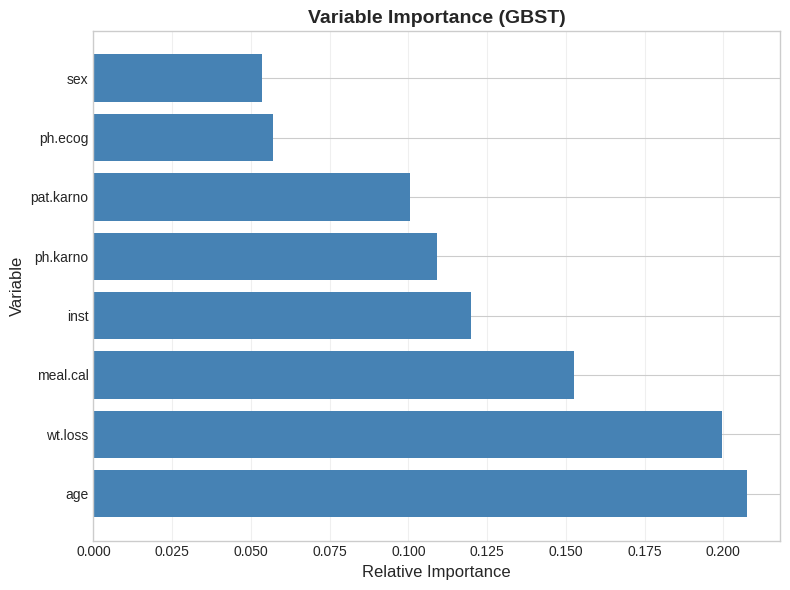

In [ ]:
# Variable importance
feature_names = train_data.drop(columns=['time', 'status']).columns
importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importance': gbst_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Variable Importance:")
print(importance_df.to_string(index=False))

# Plot variable importance
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Variable'], importance_df['Importance'], color='steelblue')
plt.title('Variable Importance (GBST)', fontsize=14, fontweight='bold')
plt.xlabel('Relative Importance', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

#### Predictioon and Validation

In [ ]:
# Predict risk scores for test data
# Refit model with optimal number of trees
gbst_model_optimal = GradientBoostingSurvivalAnalysis(
    n_estimators=best_iter,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.5,
    min_samples_split=10,
    random_state=123
)
gbst_model_optimal.fit(X_train_gbst, y_train_gbst)

risk_scores = gbst_model_optimal.predict(X_test_gbst)
print(f"Cox GBM Risk Scores (first 10): {risk_scores[:10]}")

Cox GBM Risk Scores (first 10): [-0.00324742 -0.11461782  0.19411916 -0.00823845 -0.1126399   0.20952533
  0.08716435 -0.07146159 -0.29153807 -0.18486134]


#### Concordance index (C-index)

In [ ]:
# Compute concordance index (C-index)
event_test_gbst = y_test_gbst['status']
time_test_gbst = y_test_gbst['time']

c_index_gbst = concordance_index_censored(
    event_indicator=event_test_gbst,
    event_time=time_test_gbst,
    estimate=-risk_scores  # Negate because higher risk = shorter survival
)[0]

print(f"C-index: {c_index_gbst:.3f}")

C-index: 0.406


#### Integrated Brier Score (IBS)

In [ ]:
# Calculate Integrated Brier Score (IBS) with eval_times within test set follow-up

# 1. Get survival functions for test set
surv_functions = gbst_model_optimal.predict_survival_function(X_test_gbst)

# 2. Choose evaluation times strictly within the observed test-time range (per sksurv doc)
min_time = y_test_gbst['time'].min()
max_time = y_test_gbst['time'].max()
# Get candidate times from the model grid, ensure they are inside [min_time, max_time)
# (exclude max_time itself; sksurv expects < max_time)
model_times = surv_functions[0].x
eval_times_gbst = model_times[(model_times >= min_time) & (model_times < max_time)]
if len(eval_times_gbst) < 2:
    raise ValueError(
        f"Could not find at least two evaluation times in test time span [{min_time}, {max_time})"
    )

# 3. Calculate survival predictions at these time grid points
surv_pred_gbst = np.array([sf(eval_times_gbst) for sf in surv_functions])

# 4. Compute IBS using valid eval_times
ibs_gbst = integrated_brier_score(
    y_train_gbst, y_test_gbst, surv_pred_gbst, eval_times_gbst
)

print(f"Integrated Brier Score (IBS): {ibs_gbst:.3f}")

Integrated Brier Score (IBS): 0.160


#### Survival Curves

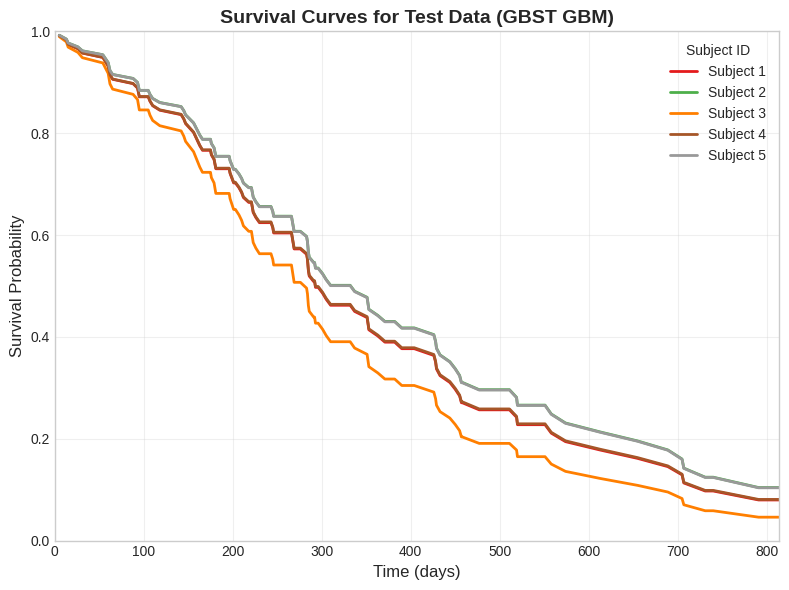

In [ ]:
# Plot survival curves for a subset of subjects
# Get survival functions for first 5 subjects
n_subjects = min(5, len(test_data))
surv_functions = gbst_model_optimal.predict_survival_function(X_test_gbst[:n_subjects])

plt.figure(figsize=(8, 6))
colors = plt.cm.Set1(np.linspace(0, 1, n_subjects))

for i in range(n_subjects):
    surv_func = surv_functions[i]
    times = surv_func.x
    surv_probs = surv_func.y
    plt.plot(times, surv_probs, linewidth=2, color=colors[i], label=f'Subject {i+1}')

plt.title('Survival Curves for Test Data (GBST GBM)', fontsize=14, fontweight='bold')
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.legend(title='Subject ID', loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, max(test_data['time']))
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

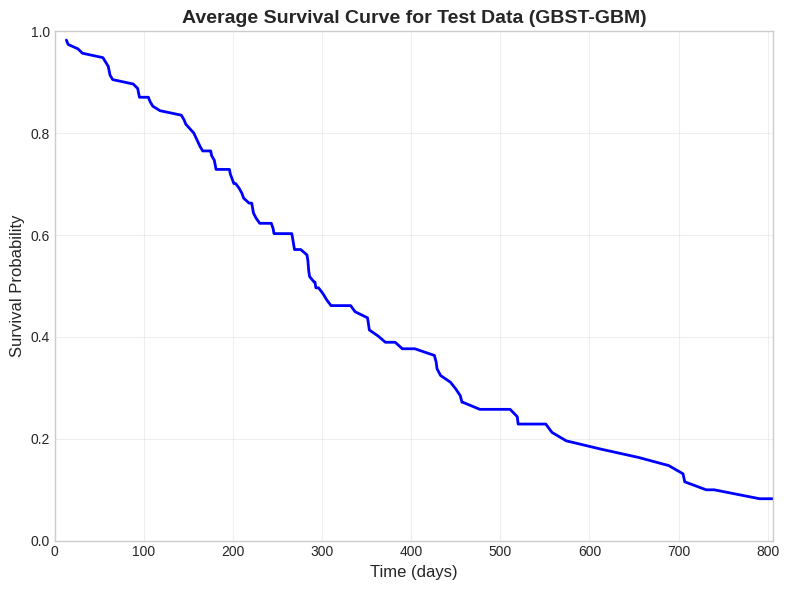

In [ ]:
# Plot average survival curve across all test subjects
avg_surv_gbst = np.mean(surv_pred_gbst, axis=0)
avg_surv_df = pd.DataFrame({
    'Time': eval_times_gbst,
    'Survival': avg_surv_gbst
})

plt.figure(figsize=(8, 6))
plt.plot(avg_surv_df['Time'], avg_surv_df['Survival'], linewidth=2, color='blue')
plt.title('Average Survival Curve for Test Data (GBST-GBM)', fontsize=14, fontweight='bold')
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, max(eval_times_gbst))
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### GBST with xgboost


The Gradient Boosting Survival Tree (GBST) model can also be implemented using the `xgboost` package in Python. This approach allows for efficient handling of large datasets and provides flexibility in defining custom loss functions for survival analysis. Below is a step-by-step guide to fitting a GBST model using `xgboost`, including data preparation, model fitting, validation, and visualization.



#### Load and Prepare Data

In [ ]:
import xgboost as xgb


# Set seed for reproducibility
np.random.seed(123)

# Prepare data: remove missing values and select relevant features
lung_clean = lung.dropna().copy()

# Convert status: 1=censored, 2=event -> 0=censored, 1=event (for xgboost)
lung_clean['status_binary'] = lung_clean['status'] - 1

# Split data into 70% training and 30% testing
train_data_xgb, test_data_xgb = train_test_split(
    lung_clean, test_size=0.3, random_state=123
)

# Prepare data for xgboost
features = ['age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss']
X_train_xgb = train_data_xgb[features].values
X_test_xgb = test_data_xgb[features].values

# For xgboost survival:cox, only time is used as label; event indicator goes in weights
dtrain_xgb = xgb.DMatrix(
    X_train_xgb,
    label=train_data_xgb['time'].values,
    weight=train_data_xgb['status_binary'].values
)
dtest_xgb = xgb.DMatrix(
    X_test_xgb,
    label=test_data_xgb['time'].values,
    weight=test_data_xgb['status_binary'].values
)


#### Train GBST Model with xgboost

In [ ]:
# Set xgboost parameters for survival: Cox objective
params_xgb = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'max_depth': 4,
    'eta': 0.1,
    'tree_method': 'hist'
}

# Train the model
xgb_model = xgb.train(
    params=params_xgb,
    dtrain=dtrain_xgb,
    num_boost_round=100,
    verbose_eval=False
)

print("XGBoost model trained successfully")

XGBoost model trained successfully


In [ ]:
# Print model summary
print(f"XGBoost Model:")
print(f"  Number of boosting rounds: 100")
print(f"  Max depth: {params_xgb['max_depth']}")
print(f"  Learning rate (eta): {params_xgb['eta']}")
print(f"  Number of features: {X_train_xgb.shape[1]}")

XGBoost Model:
  Number of boosting rounds: 100
  Max depth: 4
  Learning rate (eta): 0.1
  Number of features: 7


#### Variable Importance

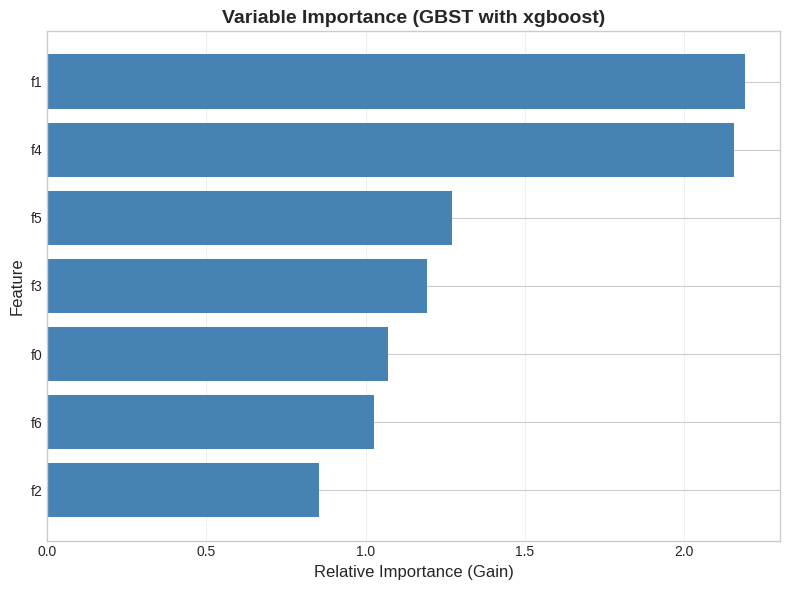

In [ ]:
# Plot variable importance
importance_xgb = xgb_model.get_score(importance_type='gain')
importance_df_xgb = pd.DataFrame({
    'Feature': list(importance_xgb.keys()),
    'Importance': list(importance_xgb.values())
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(importance_df_xgb['Feature'], importance_df_xgb['Importance'], color='steelblue')
plt.title('Variable Importance (GBST with xgboost)', fontsize=14, fontweight='bold')
plt.xlabel('Relative Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

#### Prediction and Evaluation

In [ ]:
# Predict risk scores (for Cox model)
pred_risk_xgb = xgb_model.predict(dtest_xgb)
print(f"Predicted risk scores shape: {pred_risk_xgb.shape}")
print(f"Sample risk scores: {pred_risk_xgb[:5]}")

Predicted risk scores shape: (51,)
Sample risk scores: [ 293.0761   556.0557  1928.9446  1474.0925   607.52844]


#### Concordance index (C-Index)

In [ ]:
# Calculate C-index (concordance index)
event_test_xgb = test_data_xgb['status_binary'].values
time_test_xgb = test_data_xgb['time'].values

cindex_xgb = concordance_index_censored(
    event_indicator=event_test_xgb.astype(bool),
    event_time=time_test_xgb,
    estimate=-pred_risk_xgb  # Negate because higher risk = shorter survival
)[0]

print(f"C-index: {cindex_xgb:.3f}")

C-index: 0.417


#### Integrated Brier Score (IBS)

In [ ]:
# Calculate Integrated Brier Score (IBS)
# Fix: Define evaluation times strictly within the observed test set follow-up period

from lifelines import CoxPHFitter

# Fit a simple Cox model on training data to get baseline hazard
train_cox_data = train_data_xgb[features + ['time', 'status_binary']].copy()
train_cox_data['status_binary'] = train_cox_data['status_binary'].astype(int)

cox_model_baseline = CoxPHFitter()
cox_model_baseline.fit(train_cox_data, duration_col='time', event_col='status_binary')

# Get baseline cumulative hazard
baseline_hazard = cox_model_baseline.baseline_cumulative_hazard_

# Restrict evaluation times strictly within observed time window of test set for IBS
min_time = test_data_xgb['time'].min()
max_time = test_data_xgb['time'].max()
times_xgb = np.linspace(min_time, max_time, 100, endpoint=False)  # avoid upper bound

# Calculate survival probabilities for each test subject
surv_prob_xgb = np.zeros((len(test_data_xgb), len(times_xgb)))

baseline_ch = np.interp(times_xgb, baseline_hazard.index.values, baseline_hazard.values.flatten())
for i in range(len(test_data_xgb)):
    risk_score = pred_risk_xgb[i]
    # Survival probability: S(t) = exp(-H0(t) * exp(risk_score))
    surv_prob_xgb[i, :] = np.exp(-baseline_ch * np.exp(risk_score))

# Prepare survival arrays for IBS calculation
y_train_xgb = np.array([(train_data_xgb['status_binary'].iloc[i] == 1,
                        train_data_xgb['time'].iloc[i])
                       for i in range(len(train_data_xgb))],
                      dtype=[('status', bool), ('time', float)])
y_test_xgb = np.array([(test_data_xgb['status_binary'].iloc[i] == 1,
                       test_data_xgb['time'].iloc[i])
                      for i in range(len(test_data_xgb))],
                     dtype=[('status', bool), ('time', float)])

# Calculate IBS
ibs_xgb = integrated_brier_score(
    y_train_xgb, y_test_xgb, surv_prob_xgb, times_xgb
)

print(f"Integrated Brier Score: {ibs_xgb:.3f}")

Integrated Brier Score: 0.433


#### Survival Curves

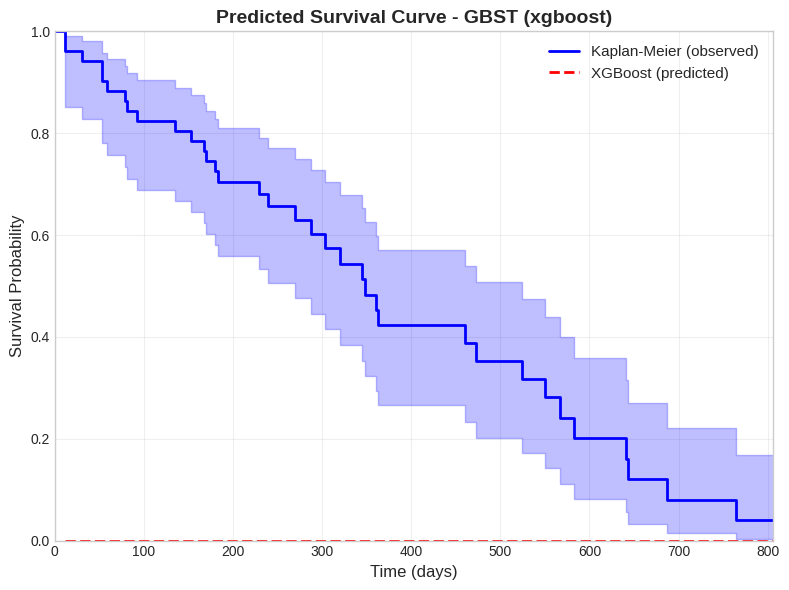

In [ ]:
# Plot survival curve
avg_surv_xgb = np.mean(surv_prob_xgb, axis=0)
surv_df_xgb = pd.DataFrame({
    'time': times_xgb,
    'surv': avg_surv_xgb
})

# Also get Kaplan-Meier estimate for comparison
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(test_data_xgb['time'], test_data_xgb['status_binary'])

plt.figure(figsize=(8, 6))
# Plot Kaplan-Meier
kmf.plot_survival_function(ax=plt.gca(), label='Kaplan-Meier (observed)',
                           color='blue', linestyle='-', linewidth=2)
# Plot XGBoost predictions
plt.plot(surv_df_xgb['time'], surv_df_xgb['surv'],
         color='red', linestyle='--', linewidth=2, label='XGBoost (predicted)')
plt.title('Predicted Survival Curve - GBST (xgboost)', fontsize=14, fontweight='bold')
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, max(times_xgb))
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Accelerated Failure Time (AFT) Gradient Boosting (AFTBoost)


Accelerated Failure Time (AFT) Gradient Boosting is a method that models survival data by assuming that the logarithm of the survival time follows a linear model. This approach allows for flexible modeling of survival times while accounting for censoring. The AFT model can be implemented using gradient boosting techniques, which iteratively fit weak learners to improve predictions. In Python, the `xgboost` package can be used to implement AFT models with the `survival:aft` objective. Below is a step-by-step guide to fitting an AFT Gradient Boosting model, including data preparation, model fitting, validation, and visualization.


#### Load and Prepare Data

In [ ]:
# Prepare lung dataset
np.random.seed(123)

# Remove missing values
lung_complete_aft = lung.dropna()

# Split into 70% training and 30% testing
train_data_aft, test_data_aft = train_test_split(
    lung_complete_aft, test_size=0.3, random_state=123
)

# Prepare data for xgboost
# Create feature matrix (exclude time and status)
features_aft = ['age', 'sex', 'ph.ecog', 'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss']
X_train_aft = train_data_aft[features_aft].values
X_test_aft = test_data_aft[features_aft].values

# For AFT, survival times are log-transformed, and status is used for censoring
# xgboost expects y_lower_bound and y_upper_bound for survival data
# For uncensored: y_lower = y_upper = log(time)
# For censored: y_lower = log(time), y_upper = Inf
y_lower_train = np.log(train_data_aft['time'].values)
y_upper_train = np.where(train_data_aft['status'] == 2,
                         np.log(train_data_aft['time'].values),
                         np.inf)  # status=2 is event

y_lower_test = np.log(test_data_aft['time'].values)
y_upper_test = np.where(test_data_aft['status'] == 2,
                       np.log(test_data_aft['time'].values),
                       np.inf)

# Create DMatrix for xgboost with labels in constructor
dtrain_aft = xgb.DMatrix(X_train_aft)
dtrain_aft.set_info(label_lower_bound=y_lower_train, label_upper_bound=y_upper_train)

dtest_aft = xgb.DMatrix(X_test_aft)
dtest_aft.set_info(label_lower_bound=y_lower_test, label_upper_bound=y_upper_test)

#### Fit AFT Gradient Boosting Model


AFT Gradient Boosting can be implemented using the `xgboost` package in R. The model is trained to minimize the negative log-likelihood of the AFT model, which can be specified through the `objective` parameter. The provided params list is used with `objective = "survival:aft"` and `eval_metric = "aft-nloglik"`. The model is trained with xgb.train for 100 boosting rounds (`nrounds = 100`).


In [ ]:
# Define parameters for AFT model
params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'tree_method': 'hist',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'max_depth': 3,
    'eta': 0.1,
    'seed': 123
}

# Fit AFT model using xgb.train
bst = xgb.train(
    params=params,
    dtrain=dtrain_aft,
    num_boost_round=100,
    verbose_eval=1
)
print(bst)

### Variable Importance

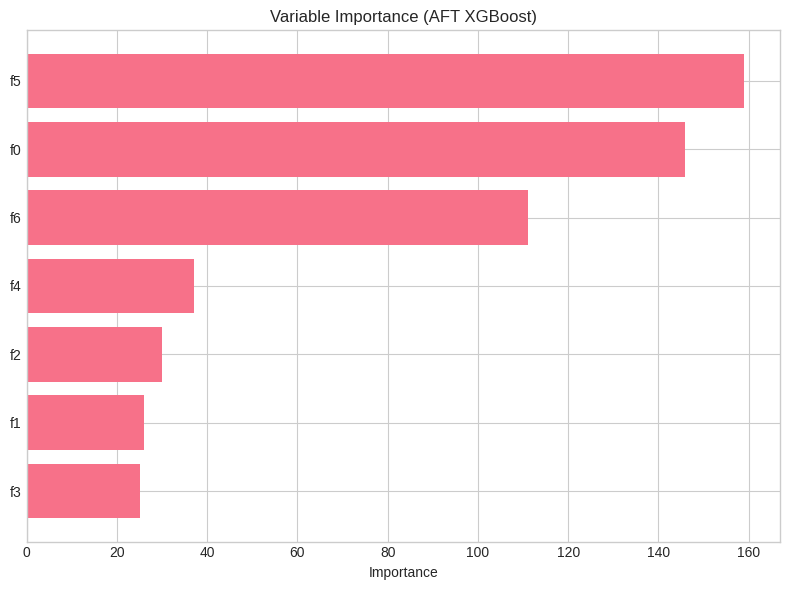

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance scores
importance_matrix = bst.get_score(importance_type='weight')
# Convert to sorted list of tuples for plotting
importance_items = sorted(importance_matrix.items(), key=lambda x: x[1], reverse=True)
feature_names, importances = zip(*importance_items)

plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Variable Importance (AFT XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Prediction and Evaluation

In [ ]:
# Predict log-survival times on test set (Python)
pred_log_time = bst.predict(dtest_aft)
pred_time = np.exp(pred_log_time)  # Exponentiate to get survival times

### Compute concordance index (C-index)

In [ ]:
from lifelines.utils import concordance_index

# Compute concordance index (C-index)
c_index = concordance_index(event_times=test_data['time'],
                           predicted_scores=pred_time,
                           event_observed=test_data['status'])
print(f"C-index: {c_index:.3f}")

C-index: 0.552


### Integrated Brier Score (IBS)

In [ ]:
import numpy as np
from lifelines import WeibullAFTFitter

# Evaluate at 100 evenly spaced times between 0 and max observed test time
eval_times = np.linspace(0, test_data['time'].max(), 100)
brier_scores = np.zeros(len(eval_times))

# Fit Weibull AFT model to the training data (assuming pandas DataFrame)
aft_model = WeibullAFTFitter()
aft_model.fit(train_data, duration_col='time', event_col='status')

# WeibullAFTFitter returns shape λ and rho for Weibull; lifelines uses a different parameterization
# Let's get estimated parameters for the intercept-only model (mean prediction)
shape = aft_model.params_['rho_']['Intercept']  # log(rho): so shape = np.exp(shape)
scale = aft_model.params_['lambda_']['Intercept']  # log(lambda): so scale = np.exp(scale)

shape = np.exp(shape)
scale = np.exp(scale)

# pred_time contains predictions from XGBoost model; we'll use these as the "scale" for each subject
# For each evaluation time, calculate survival probability and Brier score
for i, t in enumerate(eval_times):
    # Survival function for Weibull: S(t) = exp(-(t / (lambda))**rho)
    surv_probs = np.exp(-((t / (pred_time * scale)) ** shape))
    # Compare indicator of survival beyond t with survival prob
    y_true = (test_data['time'] > t).astype(float).values
    brier_scores[i] = np.mean((y_true - surv_probs) ** 2)

ibs = np.mean(brier_scores)
print(f"Integrated Brier Score (IBS): {ibs:.3f}")

Integrated Brier Score (IBS): 0.628


### Survival Curves

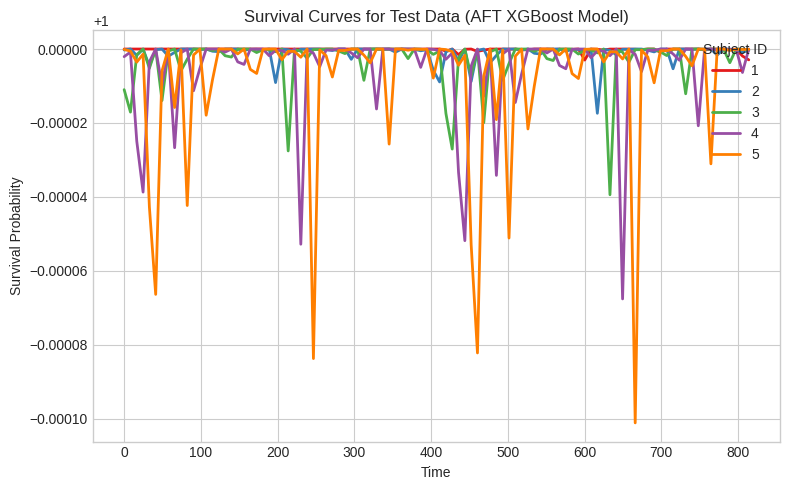

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate survival curves
# Predict survival probabilities for test data
surv_probs = np.empty((len(test_data), len(eval_times)))
for i in range(len(test_data)):
    surv_probs[i, :] = np.exp(-((eval_times / (pred_time[i] * scale)) ** shape))

# Create data frame for plotting
surv_df = pd.DataFrame({
    'Time': np.tile(eval_times, len(test_data)),
    'Survival': surv_probs.T.flatten(),
    'Subject': np.repeat(np.arange(1, len(test_data)+1), len(eval_times)),
})

# Plot survival curves for a subset of subjects (first 5 for clarity)
subset_subjects = np.arange(1, min(5, len(test_data)) + 1)
surv_df_subset = surv_df[surv_df['Subject'].isin(subset_subjects)]

import seaborn as sns
plt.figure(figsize=(8,5))
sns.lineplot(data=surv_df_subset, x='Time', y='Survival', hue='Subject', palette='Set1', linewidth=2)
plt.title("Survival Curves for Test Data (AFT XGBoost Model)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title='Subject ID', loc='upper right')
plt.tight_layout()
plt.show()

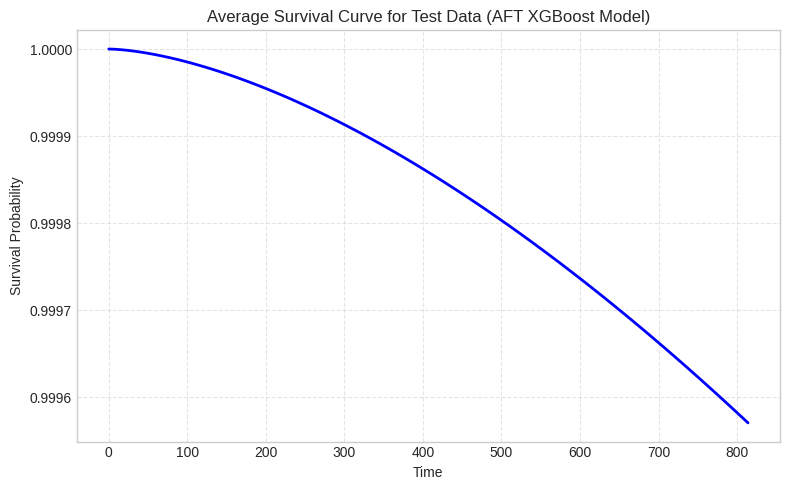

In [ ]:
# Plot average survival curve in Python
avg_surv = np.mean(surv_probs, axis=0)
avg_surv_df = pd.DataFrame({'Time': eval_times, 'Survival': avg_surv})

plt.figure(figsize=(8,5))
plt.plot(avg_surv_df['Time'], avg_surv_df['Survival'], linewidth=2, color='blue')
plt.title("Average Survival Curve for Test Data (AFT XGBoost Model)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Survival Gradient Boosting with Custom Loss Functions


Survival Gradient Boosting with custom loss functions allows for flexible modeling of survival data by defining specific loss functions that capture the characteristics of the survival outcome. This approach can be particularly useful when standard loss functions do not adequately represent the underlying survival process. In R, packages like {xgboost} and {gbm} can be used to implement survival gradient boosting with custom loss functions. Below is a step-by-step guide to fitting a survival gradient boosting model with a custom loss function, including data preparation, model fitting, validation, and visualization.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
import warnings
warnings.filterwarnings('ignore')

### Load and Prepare Data

In [ ]:
# Data and Data Preparation in Python (already provided)
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/lung_dataset.csv"
lung = pd.read_csv(url)
lung_complete = lung.dropna()

# Split into 70% training and 30% testing
train_data, test_data = train_test_split(lung_complete, test_size=0.3, random_state=123)

# Training data
time_train = train_data['time'].values
status_train = (train_data['status'] - 1).values  # Convert to 0=censored, 1=event
X_train = train_data.drop(columns=['time', 'status'])
X_train_matrix = X_train.values

# Test data
time_test = test_data['time'].values
status_test = (test_data['status'] - 1).values  # Convert to 0=censored, 1=event
X_test = test_data.drop(columns=['time', 'status'])
X_test_matrix = X_test.values

# Prepare Data for XGBoost
# Create XGBoost DMatrix
dtrain = xgb.DMatrix(X_train_matrix, label=time_train, weight=status_train)
dtest = xgb.DMatrix(X_test_matrix, label=time_test, weight=status_test)

### Fit Survival Gradient Boosting Model with Custom Loss Function

In [ ]:
### Custom Objective Function for Cox Proportional Hazards
def cox_objective(preds, dtrain):
    """
    Custom objective function for Cox proportional hazards
    Approximates the negative partial log-likelihood gradient and Hessian
    """
    y_true = dtrain.get_label()  # Time-to-event or censoring time
    event_observed = dtrain.get_weight()  # Event indicator (1=event, 0=censored)

    # Sort by time in descending order for risk set
    order = np.argsort(-y_true)
    preds_sorted = preds[order]
    y_true_sorted = y_true[order]
    event_observed_sorted = event_observed[order]

    # Clip predictions to prevent numerical overflow in exp()
    # Using a common range for log-hazard ratios to ensure stability
    preds_sorted_clipped = np.clip(preds_sorted, -10, 10)

    # Calculate risk set sum
    exp_preds_sorted = np.exp(preds_sorted_clipped) # Use clipped predictions here
    risk_set_sum = np.cumsum(exp_preds_sorted[::-1])[::-1]  # Cumulative sum from the end

    # Avoid division by zero with a small epsilon
    risk_set_sum = np.maximum(risk_set_sum, 1e-12)

    # Calculate ratio term for gradient and hessian
    ratio = exp_preds_sorted / risk_set_sum

    # Gradient and Hessian
    gradient = -event_observed_sorted + event_observed_sorted * ratio
    # Simplified Hessian for event_observed_sorted (0 or 1)
    hessian = event_observed_sorted * ratio * (1 - ratio)

    # Reorder back to original
    reorder = np.argsort(order)
    return gradient[reorder], hessian[reorder]

### Train the Model

In [ ]:
### Train the Model
# Define XGBoost parameters
params = {
    'eta': 0.05,  # Learning rate
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 123,
    'nthread': -1,  # Use all available cores
    'tree_method': 'hist'
}

# Number of boosting rounds
num_boost_round = 100

print(f"Training XGBoost model with {num_boost_round} boosting rounds...")

# Train the model
initial_xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    obj=cox_objective,
    verbose_eval=10
)

Training XGBoost model with 100 boosting rounds...
[0]	train-rmse:334.08633	eval-rmse:385.31929
[10]	train-rmse:326.53648	eval-rmse:377.99037
[20]	train-rmse:319.13265	eval-rmse:370.80289
[30]	train-rmse:311.86283	eval-rmse:363.74427
[40]	train-rmse:304.59800	eval-rmse:356.72709
[50]	train-rmse:297.27523	eval-rmse:349.64346
[60]	train-rmse:290.26089	eval-rmse:342.85442
[70]	train-rmse:283.31476	eval-rmse:336.09192
[80]	train-rmse:276.50902	eval-rmse:329.49584
[90]	train-rmse:269.88637	eval-rmse:323.06335
[99]	train-rmse:264.24836	eval-rmse:317.54271


### Prediction and Evaluation

In [ ]:
### Prediction and Evaluation
# Predict log partial hazards
train_preds = initial_xgb_model.predict(dtrain)
test_preds = initial_xgb_model.predict(dtest)

# Check for NaN values
print(f"Train predictions - NaN count: {np.sum(np.isnan(train_preds))}")
print(f"Test predictions - NaN count: {np.sum(np.isnan(test_preds))}")

# Replace any NaN values with median (this will now work if there are some non-NaN values)
if np.sum(np.isnan(train_preds)) > 0:
    # If all are NaN, nanmedian will be NaN. Provide a default if it's still NaN after computing.
    median_val = np.nanmedian(train_preds)
    if np.isnan(median_val): # If all predictions were NaN, replace with 0 (or a sensible default)
        train_preds[np.isnan(train_preds)] = 0.0
    else:
        train_preds[np.isnan(train_preds)] = median_val

if np.sum(np.isnan(test_preds)) > 0:
    median_val = np.nanmedian(test_preds)
    if np.isnan(median_val):
        test_preds[np.isnan(test_preds)] = 0.0
    else:
        test_preds[np.isnan(test_preds)] = median_val

### Concordance Index (C-index)
# Calculate C-index
train_cindex = concordance_index_censored(
    status_train.astype(bool),
    time_train,
    train_preds
)[0]

test_cindex = concordance_index_censored(
    status_test.astype(bool),
    time_test,
    test_preds
)[0]

print(f"\nInitial XGBoost model C-index (Train): {train_cindex:.3f}")
print(f"Initial XGBoost model C-index (Test): {test_cindex:.3f}")

Train predictions - NaN count: 0
Test predictions - NaN count: 0

Initial XGBoost model C-index (Train): 0.435
Initial XGBoost model C-index (Test): 0.412


### Variable Importance

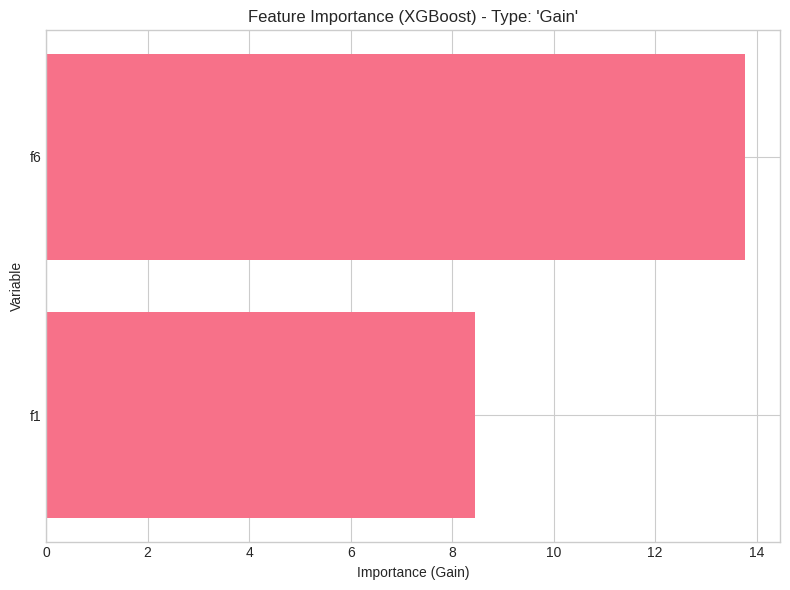

In [ ]:
### Variable Importance
# Get feature importance
importance_xgb = initial_xgb_model.get_score(importance_type='gain')

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': list(importance_xgb.keys()),
    'Gain': list(importance_xgb.values())
}).sort_values('Gain', ascending=True)

# Plot variable importance
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Gain'])
plt.title("Feature Importance (XGBoost) - Type: 'Gain'")
plt.xlabel("Importance (Gain)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

### Calculate Servival Probabilites and Brier Score

In [ ]:
### Calculate survival probabilities and Brier score
def calculate_survival_probabilities(model, X_matrix_to_predict, X_train_matrix_for_baseline, time_train_for_baseline, status_train_for_baseline, eval_times):
    """Calculate survival probabilities using Breslow estimator"""
    # 1. Get predictions for the training data to estimate the baseline hazard
    preds_train_for_baseline = model.predict(xgb.DMatrix(X_train_matrix_for_baseline))
    # Clip predictions to prevent numerical issues with exp()
    preds_train_for_baseline = np.clip(preds_train_for_baseline, -10, 10)
    preds_train_for_baseline = np.nan_to_num(preds_train_for_baseline, nan=0.0)
    train_hazard_ratios_for_baseline = np.exp(preds_train_for_baseline)

    # Sort training data by time (using the original time_train and status_train)
    train_sorted_idx = np.argsort(time_train_for_baseline)
    time_train_sorted = time_train_for_baseline[train_sorted_idx]
    status_train_sorted = status_train_for_baseline[train_sorted_idx]
    # Use hazard ratios from the training data, sorted according to training times
    hazard_ratios_sorted_for_baseline = train_hazard_ratios_for_baseline[train_sorted_idx]

    # Get unique event times from training data
    unique_event_times = np.unique(time_train_sorted[status_train_sorted == 1])
    baseline_cumulative_hazard = np.zeros(len(unique_event_times))

    cumulative_hazard = 0
    for i, event_time in enumerate(unique_event_times):
        # Find at-risk individuals from the sorted training data
        at_risk = time_train_sorted >= event_time
        sum_hazard_ratios = np.sum(hazard_ratios_sorted_for_baseline[at_risk])

        # Number of events at this time in training data
        events_at_time = np.sum((time_train_sorted == event_time) & (status_train_sorted == 1))

        if sum_hazard_ratios > np.finfo(float).eps:
            hazard_increment = events_at_time / sum_hazard_ratios
        else:
            hazard_increment = 0

        cumulative_hazard += hazard_increment
        baseline_cumulative_hazard[i] = cumulative_hazard

    # Add time 0 with hazard 0
    baseline_times = np.concatenate([[0], unique_event_times])
    baseline_values = np.concatenate([[0], baseline_cumulative_hazard])

    # Create interpolation function for baseline cumulative hazard
    baseline_hazard_func = interp1d(
        baseline_times,
        baseline_values,
        kind='linear',
        bounds_error=False,
        fill_value=(0, baseline_values[-1])
    )

    # 2. Get predictions for the X_matrix_to_predict
    preds_for_prediction = model.predict(xgb.DMatrix(X_matrix_to_predict))
    # Clip predictions to prevent numerical issues with exp()
    preds_for_prediction = np.clip(preds_for_prediction, -10, 10)
    preds_for_prediction = np.nan_to_num(preds_for_prediction, nan=0.0)
    hazard_ratios_for_prediction = np.exp(preds_for_prediction)

    survival_probs = np.zeros((len(hazard_ratios_for_prediction), len(eval_times)))

    for i, t in enumerate(eval_times):
        lambda0_t = baseline_hazard_func(t)
        survival_probs[:, i] = np.exp(-lambda0_t * hazard_ratios_for_prediction)

    return survival_probs, baseline_hazard_func


    # Define evaluation times
eval_times = np.linspace(0, max(time_test), 100)

# Calculate survival probabilities for test data
test_survival_probs, baseline_hazard_func = calculate_survival_probabilities(
    initial_xgb_model, X_test_matrix, X_train_matrix, time_train, status_train, eval_times
)

# Kaplan-Meier for censoring distribution
# Create structured array for survival data
y_test_censoring = np.array(
    [(status_test[j] == 0, time_test[j]) for j in range(len(time_test))],
    dtype=[('cens', '?'), ('time', '<f8')]
)

# Fit Kaplan-Meier for censoring distribution
time_censoring, surv_prob_censoring = kaplan_meier_estimator(
    y_test_censoring['cens'],
    y_test_censoring['time']
)

# Create interpolation function for censoring survival probabilities
censoring_surv_func = interp1d(
    time_censoring,
    surv_prob_censoring,
    kind='previous',
    bounds_error=False,
    fill_value=(1.0, np.min(surv_prob_censoring))
)

# Calculate Brier score at each evaluation time
xgboost_brier = np.zeros(len(eval_times))

for i, t in enumerate(eval_times):
    predicted_surv = test_survival_probs[:, i]
    brier_scores = np.zeros(len(time_test))

    for j in range(len(time_test)):
        G_min_Tt = censoring_surv_func(min(time_test[j], t))
        G_min_Tt = max(G_min_Tt, 1e-12)  # Avoid division by zero

        if time_test[j] <= t and status_test[j] == 1:
            score_component = (0 - predicted_surv[j]) ** 2 / G_min_Tt
        elif time_test[j] > t:
            score_component = (1 - predicted_surv[j]) ** 2 / G_min_Tt
        else:
            score_component = 0

        brier_scores[j] = score_component

    xgboost_brier[i] = np.nanmean(brier_scores)

# Integrated Brier Score (IBS) for XGBoost model
xgboost_ibs = np.trapz(xgboost_brier, eval_times) / (eval_times[-1] - eval_times[0])
print(f"\nXGBoost model IBS: {xgboost_ibs:.3f}")


XGBoost model IBS: 0.168


### Kaplan-Meier baseline IBS

In [ ]:
### Kaplan-Meier baseline IBS
# Fit Kaplan-Meier for survival
y_test = np.array(
    [(status_test[j] == 1, time_test[j]) for j in range(len(time_test))],
    dtype=[('event', '?'), ('time', '<f8')]
)

time_km, surv_prob_km = kaplan_meier_estimator(
    y_test['event'],
    y_test['time']
)

# Create interpolation function for KM survival
km_surv_func = interp1d(
    time_km,
    surv_prob_km,
    kind='previous',
    bounds_error=False,
    fill_value=(1.0, np.min(surv_prob_km))
)

# Calculate Brier score for KM baseline
km_brier = np.zeros(len(eval_times))

for i, t in enumerate(eval_times):
    km_surv = km_surv_func(t)
    brier_scores = np.zeros(len(time_test))

    for j in range(len(time_test)):
        G_min_Tt = censoring_surv_func(min(time_test[j], t))
        G_min_Tt = max(G_min_Tt, 1e-12)  # Avoid division by zero

        if time_test[j] <= t and status_test[j] == 1:
            score_component = (0 - km_surv) ** 2 / G_min_Tt
        elif time_test[j] > t:
            score_component = (1 - km_surv) ** 2 / G_min_Tt
        else:
            score_component = 0

        brier_scores[j] = score_component

    km_brier[i] = np.nanmean(brier_scores)

# Calculate Integrated Brier Score (IBS) for Kaplan-Meier baseline
km_ibs = np.trapz(km_brier, eval_times) / (eval_times[-1] - eval_times[0])
print(f"Kaplan-Meier baseline IBS: {km_ibs:.3f}")

Kaplan-Meier baseline IBS: 0.165


### Survival Curve

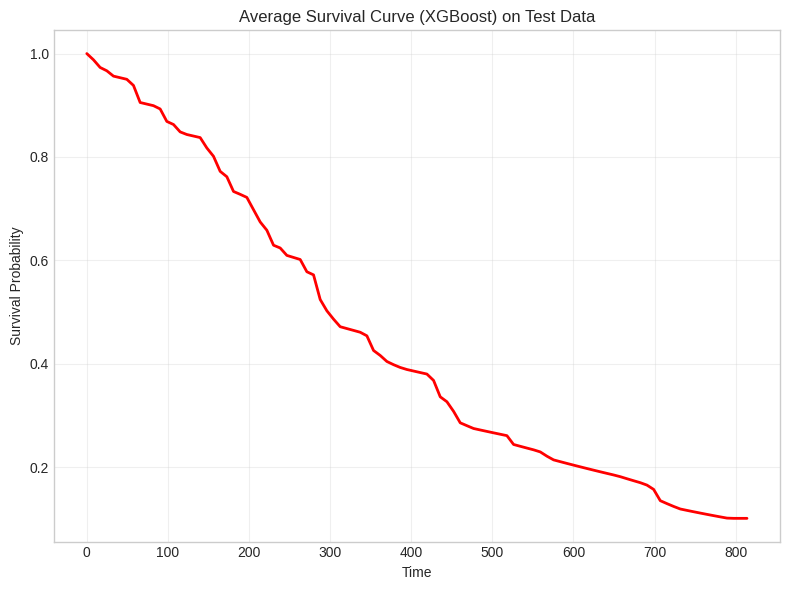

In [ ]:
### Survival Curve
# Calculate average survival curve
average_surv_xgboost = np.mean(test_survival_probs, axis=0)

# Plot survival curve
plt.figure(figsize=(8, 6))
plt.plot(eval_times, average_surv_xgboost, color='red', linewidth=2)
plt.title("Average Survival Curve (XGBoost) on Test Data")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

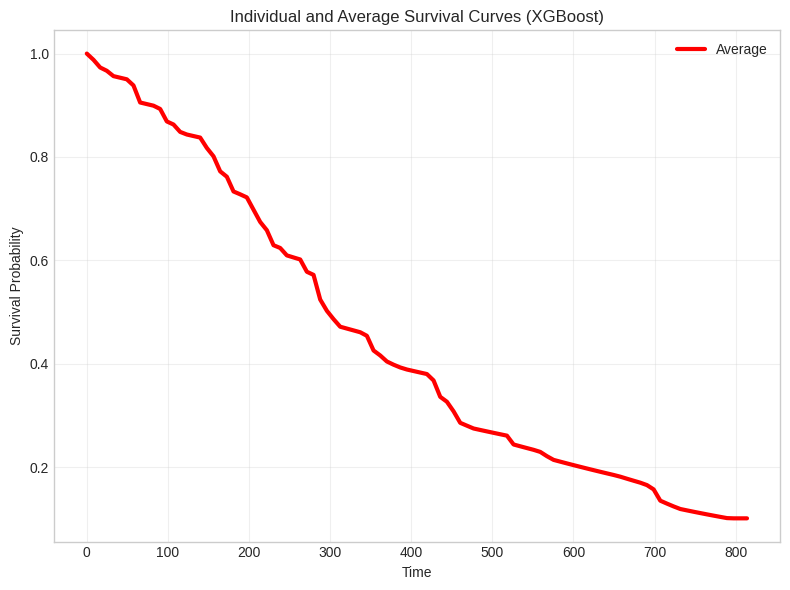

In [ ]:
# Also plot individual survival curves for a few samples
plt.figure(figsize=(8, 6))
for i in range(min(5, len(test_survival_probs))):
    plt.plot(eval_times, test_survival_probs[i], alpha=0.5, linewidth=1)
plt.plot(eval_times, average_surv_xgboost, color='red', linewidth=3, label='Average')
plt.title("Individual and Average Survival Curves (XGBoost)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary and Conclusion


This notebook explores three types of Gradient Boosted Survival Models and their implementations in R: CoxBoost, GBST, and AFTBoost.

**CoxBoost** model extends the Cox proportional hazards model using gradient boosting to model the log-hazard function. It assumes proportional hazards and optimizes the negative log-partial likelihood. The notebook demonstrates its implementation using the `{CoxBoost}` package, including data preparation, model fitting, cross-validation for penalty and steps, prediction, and evaluation using C-index and Integrated Brier Score (IBS).

**GBST (Gradient Boosting Survival Trees)** is a generic framework that applies gradient boosting to survival data using tree-based models and survival-specific loss functions. CoxBoost is a special case of GBST. The notebook shows implementations using both the `{gbm}` package (with `distribution = "coxph"`) and the `{xgboost}` package (with `objective = "survival:cox"`), covering data preparation, model fitting, cross-validation (for `{gbm}`), variable importance, prediction, and evaluation with C-index and IBS.

**AFTBoost (Accelerated Failure Time Gradient Boosting)**  models the logarithm of the survival time as a linear function of covariates, assuming predictors accelerate or decelerate the time to an event. The notebook demonstrates its implementation using the `{xgboost}` package (with `objective = "survival:aft"`), including data preparation (using `label_lower_bound` and `label_upper_bound`), model fitting, variable importance, prediction of log-survival times, and evaluation with C-index and IBS.


The notebook successfully demonstrates the implementation of three different gradient boosted survival models in R using the `{CoxBoost}`, `{gbm}`, and `{xgboost}` packages. Each model offers a distinct approach to survival analysis, with CoxBoost and GBST focusing on hazard-based modeling (often using the Cox partial likelihood) and AFTBoost directly modeling survival times. The examples provided cover essential steps like data preparation, model fitting, hyperparameter tuning (through cross-validation), assessing variable importance, and evaluating model performance using metrics like C-index and IBS. The visualizations of survival curves offer insights into the models' predictions. The notebook serves as a valuable introduction to applying gradient boosting techniques to time-to-event data in R.



## References


1. Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. *KDD '16*, 785–794.  


2. Hothorn, T., et al. (2006). Survival Ensembles. *Biostatistics, 7*(3), 355–373.  

3. Li, K., et al. (2022). Efficient Gradient Boosting for Prognostic Biomarker Discovery. *Bioinformatics, 38*(6), 1631–1638.  

4. Wang, Z., & Wang, C. Y. (2018). Gradient Boosting for Concordance Index. *Comput Math Methods Med, 2018*, 8734680.  
  

5. Zhang, H., et al. (2019). Gradient Boosting Survival Tree. *arXiv:1908.03385*.  